______

## 3.2 Tensorflow: Image Classification.

In image classification, we have a set of couples (input, output) and we are interested to get a predictor that can map inputs (images) and outputs (labels) correctly. For example, if you have a bunch of labeled images of dogs and cats, you can train a model to distinguish dogs from cats. Below, you have some important things to settle before starting training. 


1. The **training set**: a set of couples (input, output). We search for functions that are capable of mapping inputs to outputs for the whole training set.  
2. The **test set**: To see whether our predictors generalize well, we use another set to test our predictors.
3. The **predictor class**: The set of possible predictors. We search among the predictor class for good ones.
4. The **loss functions**: The loss should be low for good predictors and should be high for bad ones. 
5. The **model**: When we combine a loss and a predictor class, we get a model.
______

### 3.2.1 Get The Data.

1. Download the dataset.
2. Split into train and test set.
2. Define loading procedures.


In [51]:
import wget, zipfile, os, random

if not os.path.isfile("data.zip"): 
    print("downloading...")
    wget.download("https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3362/31148/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1678299698&Signature=b6XuKNXvsSuBcv2SZYiTqcfr7Mc%2FjpSR%2BptWRsmjRTHr1vqLdnpC6k9YaLk%2BMRSmTeZcOXGFg21TGUyv9RR7TctRcWLW8WhIdibLM2BTLqc2YCM5ZXU9DkwYRypzgmXjZs4U%2B2n4AeOzO2w7CJFnxgjOeOtAamziNd5F07aiSap1A8b2PwtClwvsQA0kx1vp0HTtT99NsWpGFY310ZOMjRnpFK17ANh5UmYAaFeHm2RVyR%2FRRVcWbVTSWKhaEDLgppgdIREZ%2FGsXpybkFAqfWGqmHkDVEpty0E3BuyGGZ8DEkDphwjHlab824Waid0IpOeOgO6qAziK5fy22dCO0Pg%3D%3D&response-content-disposition=attachment%3B+filename%3Ddogs-vs-cats.zip", "data.zip")

if not (os.path.isdir("data") and os.path.isdir("data/train") and os.path.isdir("data/test1")): 
    print("extracting...")
    with zipfile.ZipFile("data.zip"      , 'r') as file: file.extractall("./data/")
    with zipfile.ZipFile("data/train.zip", 'r') as file: file.extractall("./data/")
    with zipfile.ZipFile("data/test1.zip", 'r') as file: file.extractall("./data/")

paths = list(map(lambda name:os.path.join("data/train",name), os.listdir("data/train/")))
random.shuffle(paths)
test_paths  = paths[:len(paths)//3]
train_paths = paths[len(paths)//3+1:]

downloading...
100% [......................................................................] 851576689 / 851576689extracting...


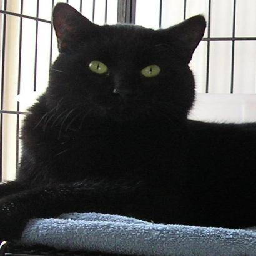

In [55]:
import random
from PIL import Image

Image.open(random.choice(train_paths)).resize((256,256), Image.NEAREST)

label: 1


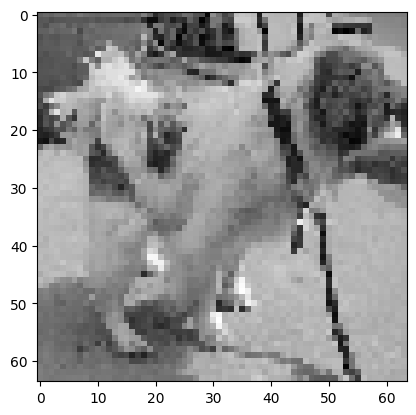

In [57]:
import random, PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def to_standard_image(path, size=(64, 64)):
    return tf.keras.utils.img_to_array(PIL.Image.open(path).resize(size, PIL.Image.NEAREST)).mean(-1)/255

def to_standard_label(path): 
    return 0 if "cat" in path else 1

def load_normalized_batch(paths, batch_size = 10, image_size = (64, 64)):
    batch = random.choices(paths, k=batch_size)
    X = np.stack([to_standard_image(p, size=image_size) for p in batch])
    Y = np.array([to_standard_label(p) for p in batch])
    return X,Y
    
X,Y = load_normalized_batch(train_paths)
plt.imshow(X[0], cmap='gray')
print(f"label: {Y[0]}")

______
### 3.2.2 Define A Model.

In tensorflow, you can define a model in many ways. One of the most flexible ways to define models is extending [tf.keras.Model]. The `__init__` should define which component you are going to use. Instead, the `call` method should define how the pre-defined components interact.   

In `tf.keras.layers` you can find a vast amount of layers. Some very common, some very specific. You can build a new layer using the predefined ones. Or, you can define new layers entirely using tensorflow Variables. 
______
#### 3.2.2.1 Dense Layer
For example one of the most common layer is the `tf.keras.layers.Dense`. It computes:

$$g(xW^T + b)$$

Where $x$ is the layer input, $x \in \mathbb{R}^{n}$. $W$ is a matrix of learnable variables, $W \in \mathbb{R}^{m\times n}$. $b$ is a vector of learnable variables, $b \in \mathbb{R}^m$. $g$ is an activation function. Without $g$, the dense layer would be a simple linear layer. Both $g$ and $m$ are hyper-parameters of choice. Why hyper-parameters? if parameters defines a class of functions, hyper-parameters define a class of class of functions. Do not think about it too much, it is just a convenient way to say that it is a parameter that you can choose as you like, and it is not trained. Often, you can find a dense layer represented as:


<center><img src="https://slugnet.jarrodkahn.com/_images/tikz-be0593f4dad31d763e7f8371668007610e7907c1.png" alt="drawing" width="400"/></center>

________

### 3.2.2.2 Convolution Layer

[Convolution] is another deep learning layer. It was originally inspired by the structure of the human visual cortex. In practice, convolution layers work extremely well with visual tasks. The Convolution layer is already defined in tensorflow and you can use it easily. Below there is a simple gif showing a convolution operation. 

* the **kernel** is the sliding window that you see below. It is composed of trainable parameters. While it slides, it computes the element-wise multiplication between the kernel and the window.
* the kernel is said to become **active** when it produces a high value. In practice, this means that it becomes active when it is multiplied against a window similar to the kernel.

<center><img src="https://theano-pymc.readthedocs.io/en/latest/_images/numerical_no_padding_no_strides.gif" alt="drawing" width="400"/></center>

In modern architectures, convolution layers are stacked on top of each other. Layers closer to the input become active for simple shapes. The layers on top activate with complex patterns formed by the features below. The figure below shows some activation patterns for low/mid/high-level layers. 

<center><img src="https://d33wubrfki0l68.cloudfront.net/05c47b9b612f8b9f2f57cae4505a4773415f3f22/b9ed6/assets/convnets/cnn20.png" alt="drawing" width="400"/></center>

_________

### 3.2.2.3 Max Pooling Layer
The [MaxPooling2D] layer is another common layer found in neural networks for vision. In practice, works similarly to the convolution layer. Instead of having a kernel of trainable parameters, it takes the maximum of each window.
______


[MaxPooling2D]:https://keras.io/api/layers/pooling_layers/max_pooling2d/
[Dense]:https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
[Convolution]:https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

In [58]:
batch_size = 100
image_size = (64,64)

class MyModel(tf.keras.Model):
    def __init__(self, batch_size, image_size):
        super(MyModel, self).__init__()
        self.reshape = tf.keras.layers.Reshape((128*128,))
        
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu') 
        self.maxp1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu') 
        self.maxp2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.flat1 = tf.keras.layers.Flatten()
        
        self.dense1  = tf.keras.layers.Dense(64, activation="relu")
        self.dense2  = tf.keras.layers.Dense(1 , activation="relu")

    def call(self, x):
        x = tf.expand_dims(x, -1)
        x = self.maxp1(self.conv1(x))
        x = self.maxp2(self.conv2(x))
        x = self.flat1(self.conv3(x))
        x = self.dense2(self.dense1(x))
        return x[:, 0]
        
lossfn = lambda preds, truths: tf.reduce_sum((preds - truths)**2)

______
### 3.2.3. Training Step

Now we can define a training step. We need to do the following things:
1. Feed data to the model.
2. Compute gradients.
3. Update model parameters (aka tensorflow variables).
4. Compute additional metrics, such as accuracy.

In [59]:
def train_step(X, Y, model):
    
    # register operations
    with tf.GradientTape() as tape:
        X = tf.cast(tf.convert_to_tensor(X), tf.float32)
        Y = tf.cast(tf.convert_to_tensor(Y), tf.float32)
        P = model(X, training=True)
        loss = lossfn(Y, P)
        
    # compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # update parameters
    for v,g in zip(model.trainable_variables, gradients): v.assign(v - 0.0001*g)
        
    # compute accuracy
    acc = tf.reduce_sum(tf.cast(Y == tf.round(P), tf.int32))/X.shape[0]
    
    return loss.numpy(), acc.numpy()

_____
### 3.2.4. Training the model
To train, we just need to repeat the training step until we are satisfied.

In [60]:
model = MyModel(batch_size, image_size)
for i in range(2000):
    X,Y = load_normalized_batch(train_paths, batch_size=batch_size, image_size=image_size)
    l,a = train_step(X, Y, model=model)
    print(f"\r batch: {i}, loss: {l}, acc: {a}", end="    ")

 batch: 1999, loss: 20.489267349243164, acc: 0.71    

______
### 3.2.4. Testing the model

To test the model, we collect the metrics on the test set, without performing any training.

In [61]:
import random

tp, fp, fn, tn = 0, 0, 0, 0
random.shuffle(test_paths)
paths = test_paths[:1000]
for i,p in enumerate(paths):
    X = to_standard_image(p, size=image_size)
    Y = to_standard_label(p)
    P = tf.round(model(X.reshape(1,image_size[0],image_size[1]), training=True)).numpy()[0]

    if Y == 1 and P == 1: tp += 1
    if Y == 0 and P == 1: fp += 1
    if Y == 1 and P == 0: fn += 1
    if Y == 0 and P == 0: tn += 1
    acc = (tp + tn) / (tp + tn + fp + fn)
    print(f"\r {i}/{len(paths)}, acc: {acc}",end="")

print(f"\ntest accuracy: {acc}")

 999/1000, acc: 0.6556556556556556
test accuracy: 0.655


_______
### 3.2.5. Improving the Model.

#### 3.2.5.1 Loss.

All losses have one thing in common, they are big when there are errors and they are small when everything is right. By minimizing a loss, you are forcing your model to behave the way you want. However, it should be noted that different losses may impact the learning process differently. Ultimately, using the right loss for your task can lead to improvements and faster convergence. Unfortunately, knowing the right loss to use is not an easy task. Luckily, tensorflow already defines several losses that you can try out easily.

One common loss for classification task is the [CategoricalCrossentropy].

[CategoricalCrossentropy]:https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
______

#### 3.2.5.2 Optimizer.

Up until now to we update the model parameter by simply computing the partial derivatives of $w$ with respect to our model $L$.  
$$ w \leftarrow w - \frac{\partial L}{\partial w} $$

This little procedure is called optimizer. It turns out that there are a lot of ways you can define an optimizer. Instead of following blindly the current gradient you can average the current gradient with previous ones. You are still doing gradient descent but with a different optimization procedure. One popular optimizer that is often used is [Adam]. Adam, among many others, is already defined in tensorflow and can be adopted easily.

______

#### 3.2.5.3 Skip-Connections.

You should know that a bigger model means that you can approximate more complex functions. However, in practice, it is not always the case. You will find yourself in many situations in which having more layers does actually hurt the results. Skip-connections are one of those mechanisms that can be useful to avoid this issue. given a layer $layer$ with input $x$ you can define a skip-connection for $x$ as follow:  

$$x = x + layer(x)$$

______

### 3.2.5.4 Pretraining

When we say nothing, tensorflow initializes the parameters randomly. This is perfectly fine for most scenarios. However, it is well known that some initializations are better than others. For example, if we were to train our model on a task for which we have many data available, we can hope that it will learn features general enough that can be useful for our task of interest. 

* When we train a model on a task with a huge dataset available with the intention of reusing its parameter later, we are doing **pretraining**.
* When we train an already trained model on another task (or a different dataset), we are doing **fine-tuning**.

Luckily, tensorflow has some pretrained models already defined so that we can just fine-tune them. Among these, one famous pretrained model is [ResNet]. ResNet relies heavily on both convolutions and skip-connections.
______

Finally, we can put everything toghether and train a much better model. 

[Adam]:https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
[ResNet]:https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

In [62]:
import tensorflow as tf
import random

class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet  = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
        self.avg     = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))
        self.dense   = tf.keras.layers.Dense(2, activation="softmax")
        self.squeeze = tf.keras.layers.Reshape((2,))
        
    def call(self, x):
        return self.squeeze(self.dense(self.avg(self.resnet(x))))
    
resnet  = ResNet()
optim   = tf.keras.optimizers.Adam(learning_rate=0.0001)
lossfn  = tf.keras.losses.CategoricalCrossentropy(from_logits=True, axis=-1,)

### TRAIN LOOP ###
for i in range(20):
    batch = random.choices(train_paths, k = 10)                                                # load a
    batchX = [tf.keras.preprocessing.image.load_img(x, target_size=(224,224)) for x in batch ] # batch
    batchY = [[1,0] if "cat" in p else [0, 1]                                 for p in batch ] # worth of
    batchX = [tf.keras.preprocessing.image.img_to_array(x)                    for x in batchX] # images
    batchX = [tf.keras.applications.resnet50.preprocess_input(x)              for x in batchX] # 
    batchX = tf.stack(batchX)                                                                  #
    batchY = tf.convert_to_tensor(batchY)                                                      #

    
    with tf.GradientTape() as tape:            # register the
        batchP = resnet(batchX, training=True) # computational 
        loss   = lossfn(batchY, batchP)        # graph

    # compute gradient and update the parameters
    gradients = tape.gradient(loss, resnet.trainable_variables)
    optim.apply_gradients(zip(gradients, resnet.trainable_variables))
    
    # compute accuracy score
    acc = tf.reduce_sum(tf.cast(tf.argmax(batchY,-1) == tf.argmax(batchP,-1), tf.int32))/batchX.shape[0]

    print(f" train {i}/{20}, loss:{loss.numpy()}, acc:{acc.numpy()}")
    
### TEST LOOP ###
tp,fp,fn,tn = 0,0,0,0
for i,p in enumerate(test_paths[:100]):
    X = tf.keras.preprocessing.image.load_img(p, target_size=(224,224))
    X = tf.keras.preprocessing.image.img_to_array(X)
    X = tf.keras.applications.resnet50.preprocess_input(X)
    X = tf.expand_dims(X,0)
    Y = [1,0] if "cat" in p else [0,1]
    Y = tf.convert_to_tensor(Y)
    Y = tf.expand_dims(Y,0)    
    
    P = resnet(X, training=False)
    
    Y, P = tf.argmax(Y,-1).numpy(), tf.argmax(P,-1).numpy()

    if Y == 1 and P == 1: tp += 1
    if Y == 0 and P == 1: fp += 1
    if Y == 1 and P == 0: fn += 1
    if Y == 0 and P == 0: tn += 1
    
    print(f"\rtest {i}/{100}, acc:{(tp + tn) / (tp + tn + fp + fn)}", end="")

94765736/94765736 [==============================] - 25s 0us/step
 train 0/20, loss:0.7154210209846497, acc:0.6
 train 1/20, loss:0.5285111665725708, acc:0.9
 train 2/20, loss:0.4566193222999573, acc:1.0
 train 3/20, loss:0.4598585069179535, acc:0.9
 train 4/20, loss:0.3857042193412781, acc:1.0
 train 5/20, loss:0.365229070186615, acc:1.0
 train 6/20, loss:0.39835071563720703, acc:1.0
 train 7/20, loss:0.5407990217208862, acc:0.7
 train 8/20, loss:0.332038938999176, acc:1.0
 train 9/20, loss:0.38245975971221924, acc:0.9
 train 10/20, loss:0.334066778421402, acc:1.0
 train 11/20, loss:0.34321027994155884, acc:1.0
 train 12/20, loss:0.38377588987350464, acc:0.9
 train 13/20, loss:0.40312933921813965, acc:0.9
 train 14/20, loss:0.41180524230003357, acc:0.9
 train 15/20, loss:0.3220749795436859, acc:1.0
 train 16/20, loss:0.3293434977531433, acc:1.0
 train 17/20, loss:0.339766263961792, acc:1.0
 train 18/20, loss:0.40588974952697754, acc:0.9
 train 19/20, loss:0.4096389710903168, acc:0.8
t

logit: [[0.03853572532534599, 0.9614643454551697]]
label: dog


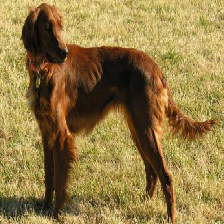

In [83]:
paths = list(map(lambda name:os.path.join("data/test1",name), os.listdir("data/test1/")))
image = tf.keras.preprocessing.image.load_img(random.choice(paths), target_size=(224,224))
X = tf.keras.preprocessing.image.img_to_array(image)
X = tf.keras.applications.resnet50.preprocess_input(X)
X = tf.expand_dims(X,0)

P = resnet(X, training=False)
label2name = {0:"cat", 1:"dog"}

print(f"logit: {P.numpy().tolist()}")
print(f"label: {label2name[tf.argmax(P,-1).numpy()[0]]}")
image